In [2]:
import random
import yfinance as yf  # import data from web (financial time series)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  ## interactive data visualization
import gym
from gym_anytrading.envs import StocksEnv, Actions
from stable_baselines3 import A2C
import math

# high-quality figures
%config InlineBackend.figure_format = 'svg'

Análise Inicial

In [98]:
qqq = yf.Ticker("KO")
data = qqq.history(start="2019-01-01", end="2024-10-31")



# plt.figure(figsize=(10, 6))
# plt.plot(data.index, data['Close'])
# plt.title('Preço das Ações (Close)')
# plt.xlabel('Datas')
# plt.ylabel('Preço (Dólares)')
# plt.legend(loc='best')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

returns = data['Close'].pct_change()
returns = returns.dropna()
cumulative_returns = (1 + returns).cumprod() - 1

initial_investment = 10000


final_value = initial_investment * (1 + cumulative_returns.iloc[-1])
print(f'Cumulative Daily Returns: {cumulative_returns.iloc[-1]*100:.2f}%')
print(f'Final Investment Value: ${final_value:.2f}')
print('')


mean_return = returns.sum() / len(returns)
print(f'Expected Mean Return: {mean_return*100:.2f}%')
print('')

variance = np.var(returns)
print(f'Variance: {variance * 100:.6f}%')

Cumulative Daily Returns: 67.94%
Final Investment Value: $16793.61

Expected Mean Return: 0.04%

Variance: 0.016439%


EMA

In [ ]:
qqq = yf.Ticker("KO")
data = qqq.history(start="2019-01-01", end="2024-10-31")

# Define the trading strategy
def trading_strategy(data, short_span=5, long_span=30):
    data['ema_short'] = data['Close'].ewm(span=short_span, adjust=False).mean()
    data['ema_long'] = data['Close'].ewm(span=long_span, adjust=False).mean()
    signals = pd.DataFrame(index=data.index)
    signals['Signal'] = np.where(data['ema_short'] > data['ema_long'], 1, 0)
    #print(signals['Signal'].value_counts())
    #print(data[['ema_short', 'ema_long']].head(10))
    return signals

# Perform backtesting
def backtest(data, signals):
    df = pd.concat([data, signals], axis=1).dropna()
    df['Return'] = df['Close'].pct_change()
    df['Cumulative Return'] = (1 + df['Return']).cumprod()
    df['Portfolio Value'] = df['Cumulative Return'] * initial_investment
    num_trading_days = len(df)
    returns = df['Return']
    cumulative_returns = df['Cumulative Return']
    annual_returns = (cumulative_returns[-1]) ** (252 / num_trading_days) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_returns / volatility
    variance = returns.var()
    cvar = returns[returns <= np.percentile(returns, 5)].mean() * 252
    return df, sharpe_ratio, annual_returns, cumulative_returns, variance, cvar

# Define initial investment
initial_investment = 10000

#Adjust spans
short_span = 10
long_span = 50

# Generate signals
signals = trading_strategy(data, short_span, long_span)

# Perform backtesting
backtest_results, sharpe_ratio, cagr, cumulative_returns, variance, cvar = backtest(data, signals)

#Plot trades
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label="Preço das Ações", color='black', alpha=0.6)
for date, signal in signals.iterrows():
    price = data.loc[date, 'Close']
    if signal['Signal'] == 1:  # Buy signal
        plt.scatter(date, price, color='green', s=8, label="Compra" if 'Compra' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif signal['Signal'] == 0:  # Sell signal
        plt.scatter(date, price, color='red', s=8, label="Venda" if 'Venda' not in plt.gca().get_legend_handles_labels()[1] else "")
plt.title('Situações de Venda e Compra (EMA)')
plt.xlabel('Datas')
plt.ylabel('Preço (Dólares)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot short and long EMA
short_rolling = data['Close'].ewm(span=short_span, adjust=False).mean()  # Short EMA
long_rolling = data['Close'].ewm(span=long_span, adjust=False).mean()  # Long EMA
start_date = '2019-01-01'
end_date = '2020-01-01'
plt.figure(figsize=(10, 6))
plt.plot(data.loc[start_date:end_date].index, data.loc[start_date:end_date, 'Close'], label='Preço das Ações', color='black', alpha=0.5)
plt.plot(long_rolling.loc[start_date:end_date].index, long_rolling.loc[start_date:end_date], label='Long Span EMA (50-dias)', color='blue')
plt.plot(short_rolling.loc[start_date:end_date].index, short_rolling.loc[start_date:end_date], label='Short Span EMA (10-dias)', color='red')
plt.legend(loc='best')
plt.title('Preço das Ações com EMA (2019-2020)')
plt.xlabel('Data')
plt.ylabel('Preço (Dólares)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Print metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"CAGR: {cagr:.2%}")
print(f"Cumulative Returns: {cumulative_returns[-1]:.2%}")
print(f"Variance: {variance*100:.6f}%")
print(f"CVaR: {cvar*100:.6f}%")



RSI

In [17]:
qqq = yf.Ticker("KO")
data = qqq.history(start="2019-01-01", end="2024-10-31")

def ge_rsi(returns, lookback):
    up = []
    down = []
    for i in range(len(returns)):
        if returns[i] < 0:
            up.append(0)
            down.append(returns[i])
        else:
            up.append(returns[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com=lookback - 1, adjust=False).mean()
    down_ewm = down_series.ewm(com=lookback - 1, adjust=False).mean()
    rs = up_ewm / down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns={0: 'rsi'}).set_index(returns.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

# Configuração do período
start_date = '2019-01-01'
end_date = '2024-10-31'

# Calcular retornos diários (variação percentual)
data['returns'] = data['Close'].pct_change()

# Calcular RSI usando a função ge_rsi
lookback = 25
rsi = ge_rsi(data['returns'], lookback)

# Alinhar índices de data e rsi
data = data.join(rsi, how='left')  # Garante que o RSI está alinhado ao índice de data

# Função para calcular métricas de backtesting
def calculate_metrics(data, initial_investment=10000):
    # Gerar sinais de compra e venda
    data['Signal'] = 0
    data.loc[data['rsi'] < 30, 'Signal'] = 1  # Buy
    data.loc[data['rsi'] > 70, 'Signal'] = -1  # Sell
    
    # Calcular o retorno da estratégia
    data['Position'] = data['Signal'].replace(0, np.nan).ffill().fillna(0)
    data['Strategy Return'] = data['Position'] * data['returns']
    data['Cumulative Return'] = (1 + data['Strategy Return']).cumprod()

    # Calcular métricas
    returns = data['Strategy Return'].dropna()
    cumulative_returns = data['Cumulative Return']
    risk_free_rate = 0  # Sem taxa livre de risco

    sharpe_ratio = (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252) if returns.std() != 0 else 0
    cagr = (cumulative_returns.iloc[-1]) ** (252 / len(data)) - 1
    variance = returns.var()
    cvar = returns[returns <= np.percentile(returns, 5)].mean()

    return sharpe_ratio, cagr, cumulative_returns.iloc[-1], variance, cvar

# Calcular métricas
sharpe_ratio, cagr, cumulative_returns, variance, cvar = calculate_metrics(data)

# Exibir métricas
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"CAGR: {cagr:.2%}")
print(f"Cumulative Returns: {cumulative_returns:.2%}")
print(f"Variance: {variance*100:.6f}%")
print(f"CVaR: {cvar*100:.6f}%")


# # Gráfico do RSI
# plt.figure(figsize=(10, 5))
# plt.plot(data.index, data['rsi'], label=f'RSI ({lookback}-dias)', color='black')
# plt.axhline(30, linestyle='--', color='blue', label='30 Oversold')
# plt.axhline(70, linestyle='--', color='orange', label='70 Overbought')

# # Colorir os pontos de compra (RSI < 30) e venda (RSI > 70)
# buy_signals = data[data['Signal'] == 1]
# sell_signals = data[data['Signal'] == -1]

# plt.scatter(buy_signals.index, buy_signals['rsi'], marker='o', color='green', label='Compra', alpha=1, zorder=5)
# plt.scatter(sell_signals.index, sell_signals['rsi'], marker='o', color='red', label='Venda', alpha=1, zorder=5)

# plt.title('Situações de Venda e Compra (RSI)')
# plt.xlabel('Datas')
# plt.ylabel(f'RSI')
# plt.legend(loc='best')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


Sharpe Ratio: 0.87
CAGR: 15.94%
Cumulative Returns: 236.64%
Variance: 0.014393%
CVaR: -2.707721%


C:\Users\Ana\AppData\Local\Temp\ipykernel_14172\224332843.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if returns[i] < 0:
C:\Users\Ana\AppData\Local\Temp\ipykernel_14172\224332843.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  up.append(returns[i])
C:\Users\Ana\AppData\Local\Temp\ipykernel_14172\224332843.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  down.append(returns[i])


Q-Learning (EMA)

In [ ]:
seed_value = 105
np.random.seed(seed_value)
random.seed(seed_value)

qqq = yf.Ticker("KO")
data = qqq.history(start="2019-01-01", end="2024-10-31")

data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data = data.dropna()

def get_state(row):
    ema_state = int(row['EMA_10'] > row['EMA_50'])  # 1 se SMA_10 > SMA_50, caso contrário 0
    return ema_state #1 Buy, 0 Sell

data.loc[:, 'State'] = data.apply(get_state, axis=1)

unique_states = data['State'].unique()
num_states = len(unique_states)

# Definir o agente Q-learning
class QLearningAgent:
    def __init__(self, num_states, num_actions, alpha, gamma):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = np.zeros((num_states, num_actions))

    def update_q_table(self, state, action, reward, next_state):
        state_idx = int(state)
        next_state_idx = int(next_state)

        # Verificar limites dos índices
        if state_idx >= self.num_states or next_state_idx >= self.num_states:
            return  # Ignorar estados fora do intervalo

        max_q_value = np.max(self.q_table[next_state_idx])
        self.q_table[state_idx, action] += self.alpha * (reward + self.gamma * max_q_value - self.q_table[state_idx, action])

    def choose_action(self, state, epsilon):
        state_idx = int(state)

        # Garantir que o estado está nos limites
        if state_idx >= self.num_states:
            return np.random.choice(self.num_actions)

        if np.random.uniform() < epsilon:  # Exploração
            return np.random.choice(self.num_actions)
        else:  # Exploração
            return np.argmax(self.q_table[state_idx])

# Estratégia de trading com Q-learning
def trading_strategy(data, q_agent, initial_investment, epsilon, epsilon_decay, min_epsilon, entry_points, exit_points):
    for episode in range(1):
        total_reward = 0
        portfolio_value = [initial_investment]
        cash = initial_investment
        shares = 0
        trades = []

        for i in range(len(data) - 1):
            state = data.iloc[i]['State']
            action = q_agent.choose_action(state, epsilon)

            # Check if an entry point exists for the current day
            if data.index[i] in entry_points or data.index[i] in exit_points:
                # Execute the recommended action
                if data.index[i] in entry_points and cash > 0:  # Ensure you have funds to buy shares
                    shares = cash // data.iloc[i]['Close']
                    cash -= shares * data.iloc[i]['Close']
                    trades.append(('BUY', data.index[i], data.iloc[i]['Close'], shares))
                elif data.index[i] in exit_points and shares > 0:  # Ensure we have shares to sell
                    cash += shares * data.iloc[i]['Close']
                    shares = 0
                    trades.append(('SELL', data.index[i], data.iloc[i]['Close'], shares))
            else:
                # Executar ação
                if action == 1 and cash > data.iloc[i]['Close']:  # Comprar
                    shares = cash // data.iloc[i]['Close']
                    cash -= shares * data.iloc[i]['Close']
                    trades.append(('BUY', data.index[i], data.iloc[i]['Close'], shares))
                elif action == 0 and shares > 0:  # Vender
                    cash += shares * data.iloc[i]['Close']
                    shares = 0
                    trades.append(('SELL', data.index[i], data.iloc[i]['Close'], shares))

            # Calcular recompensa
            portfolio = cash + shares * data.iloc[i]['Close']
            reward = portfolio - portfolio_value[-1]
            total_reward += reward
            portfolio_value.append(portfolio)

            # Atualizar a tabela Q
            next_state = data.iloc[i + 1]['State']
            q_agent.update_q_table(state, action, reward, next_state)

        # Atualizar epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

    return total_reward, portfolio_value, trades

# Parâmetros do Q-learning
al = 0.1  # Taxa de aprendizado
gam = 0.95  # Fator de desconto
epsilon = 1  # Taxa de exploração
epsilon_decay = 0.995
min_epsilon = 0.01

# entry_points = {
#     '2020-03-16': 'BUY',  # COVID WORLD PANDEMIC DECLARATION
#     '2022-09-01': 'BUY',  # MID-TERM ELECTIONS
#     '2023-08-01': 'BUY'   # FEDERAL RESERVE MONETARY POLICY UPDATE
# }

# exit_points = {
#     '2020-02-05': 'SELL', # PRE PANDEMIC WARNING
#     '2022-01-13': 'SELL', # RELEASE OF POSITIVE ECONOMICAL FORECAST
#     '2024-09-03': 'SELL'  # INTEREST RATE REDUCTION
# }

entry_points = {}
exit_points = {}

# Configuração inicial
initial_investment = 10000
num_states = data['State'].nunique()
num_actions = 2  # Comprar ou Vender

q_agent = QLearningAgent(num_states=num_states, num_actions=num_actions, alpha=al, gamma=gam)
# Aplicar a estratégia de trading
total_reward, portfolio_value, trades = trading_strategy(data, q_agent, initial_investment, epsilon, epsilon_decay, min_epsilon, entry_points, exit_points)

# Métricas de desempenho
returns = np.diff(portfolio_value) / portfolio_value[:-1]
sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)
cumulative_returns = (portfolio_value[-1] - portfolio_value[0]) / portfolio_value[0]
portfolio_value = np.array(portfolio_value)
num_years = len(data) / 252  # Aproximadamente 252 dias úteis por ano
cagr = (portfolio_value[-1] / portfolio_value[0]) ** (1 / num_years) - 1
variance = np.var(returns)
confidence_level = 5
var_threshold = np.percentile(returns, confidence_level)
cvar = np.mean(returns[returns < var_threshold])

daily_returns = np.diff(portfolio_value) / portfolio_value[:-1]
compound_cumulative_return = np.prod(1 + daily_returns) - 1


# Exibir métricas
print(f'Sharpe Ratio: {sharpe_ratio:.3f}')
print(f'CAGR: {cagr * 100:.2f}%')
print(f'Cumulative Returns: {cumulative_returns * 100:.2f}%')
print(f'Compound Cumulative Return: {compound_cumulative_return * 100:.2f}%')
print(f'Variance: {variance * 100:.6f}%')
print(f'CVaR (5%): {cvar * 100:.6f}%')
print(f'Final Portfolio Value: ${portfolio_value[-1]:.2f}')

# plt.figure(figsize=(10, 6))
# plt.plot(data.index, data['Close'], label="Preço das Ações", color='black', alpha=0.5)
# for trade in trades:
#     action, date, price, shares = trade
#     if action == 'BUY':
#         plt.scatter(date, price, s=8, color='green', label="Compra" if 'Compra' not in plt.gca().get_legend_handles_labels()[1] else "")
#     elif action == 'SELL':
#         plt.scatter(date, price, s=8, color='red', label="Venda" if 'Venda' not in plt.gca().get_legend_handles_labels()[1] else "")
# plt.title('Situações de Venda e Compra (Q-learning)')
# plt.xlabel('Datas')
# plt.ylabel('Preço (Dólares)')
# plt.legend(loc='best')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Sharpe Ratio: 0.643
CAGR: 8.80%
Cumulative Returns: 63.43%
Compound Cumulative Return: 63.43%
Variance: 0.008743%
CVaR (5%): -2.295642%
Final Portfolio Value: $16342.53


Q-Learning (RSI e SMA)

In [102]:
# Configurar seed para reprodutibilidade
seed_value = 20
np.random.seed(seed_value)
random.seed(seed_value)

qqq = yf.Ticker("KO")
data = qqq.history(start="2019-01-01", end="2024-10-31")

data.loc[:, 'SMA_10'] = data['Close'].rolling(window=10).mean()
data.loc[:, 'SMA_50'] = data['Close'].rolling(window=50).mean()
data = data.dropna()

# Função para calcular o RSI com parâmetros 70-30 e 25 dias
def get_rsi(data, lookback=25):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=lookback).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=lookback).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Adicionar RSI ao dataframe
data['RSI'] = get_rsi(data)  # Adiciona a coluna RSI
data = data.dropna()  # Remove valores NaN

# Discretizar o RSI e criar um estado combinado com SMA
def get_state_with_rsi(row):
    sma_state = int(row['SMA_10'] > row['SMA_50'])  # 1 se SMA_10 > SMA_50, caso contrário 0
    rsi_state = 0
    if row['RSI'] > 70:
        rsi_state = 2  # Sobrecomprado
    elif row['RSI'] < 30:
        rsi_state = 1  # Sobrevendido
    return sma_state * 10 + rsi_state  # Combina estados SMA e RSI

# Atualizar o dataframe com estados
data['State'] = data.apply(get_state_with_rsi, axis=1)
unique_states = data['State'].unique()
num_states = len(unique_states)

# Definir o agente Q-learning
class QLearningAgent:
    def __init__(self, num_states, num_actions, alpha, gamma):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = np.zeros((num_states, num_actions))

    def update_q_table(self, state, action, reward, next_state):
        state_idx = int(state)
        next_state_idx = int(next_state)

        # Verificar limites dos índices
        if state_idx >= self.num_states or next_state_idx >= self.num_states:
            return  # Ignorar estados fora do intervalo

        max_q_value = np.max(self.q_table[next_state_idx])
        self.q_table[state_idx, action] += self.alpha * (reward + self.gamma * max_q_value - self.q_table[state_idx, action])

    def choose_action(self, state, epsilon):
        state_idx = int(state)

        # Garantir que o estado está nos limites
        if state_idx >= self.num_states:
            return np.random.choice(self.num_actions)

        if np.random.uniform() < epsilon:  # Exploração
            return np.random.choice(self.num_actions)
        else:  # Exploração
            return np.argmax(self.q_table[state_idx])

# Estratégia de trading com Q-learning
def trading_strategy(data, q_agent, initial_investment, epsilon, epsilon_decay, min_epsilon):
    total_reward = 0
    portfolio_value = [initial_investment]
    cash = initial_investment
    shares = 0

    for i in range(len(data) - 1):
        state = data.iloc[i]['State']
        action = q_agent.choose_action(state, epsilon)

        # Executar ação
        if action == 1 and cash > data.iloc[i]['Close']:  # Comprar
            shares = cash // data.iloc[i]['Close']
            cash -= shares * data.iloc[i]['Close']
        elif action == 0 and shares > 0:  # Vender
            cash += shares * data.iloc[i]['Close']
            shares = 0

        # Calcular recompensa
        portfolio = cash + shares * data.iloc[i]['Close']
        reward = portfolio - portfolio_value[-1]
        total_reward += reward
        portfolio_value.append(portfolio)

        # Atualizar a tabela Q
        next_state = data.iloc[i + 1]['State']
        q_agent.update_q_table(state, action, reward, next_state)

        # Atualizar epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

    return total_reward, portfolio_value

# Parâmetros do Q-learning
alpha = 0.1  # Taxa de aprendizado
gamma = 0.95  # Fator de desconto
epsilon = 1.0  # Taxa de exploração
epsilon_decay = 0.995
min_epsilon = 0.01

# Configuração inicial
initial_investment = 10000
num_states = data['State'].nunique()
num_actions = 2  # Comprar ou Vender


# Aplicar a estratégia de trading
q_agent = QLearningAgent(num_states=num_states, num_actions=num_actions, alpha=alpha, gamma=gamma)
total_reward, portfolio_value = trading_strategy(data, q_agent, initial_investment, epsilon, epsilon_decay, min_epsilon)

# Métricas de desempenho
returns = np.diff(portfolio_value) / portfolio_value[:-1]
sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)
cumulative_returns = (portfolio_value[-1] - portfolio_value[0]) / portfolio_value[0]
portfolio_value = np.array(portfolio_value)
num_years = len(data) / 252  # Aproximadamente 252 dias úteis por ano
cagr = (portfolio_value[-1] / portfolio_value[0]) ** (1 / num_years) - 1
variance = np.var(returns)
confidence_level = 5
var_threshold = np.percentile(returns, confidence_level)
cvar = np.mean(returns[returns < var_threshold])

daily_returns = np.diff(portfolio_value) / portfolio_value[:-1]
compound_cumulative_return = np.prod(1 + daily_returns) - 1

# Exibir métricas
print(f'Sharpe Ratio: {sharpe_ratio:.3f}')
print(f'Cumulative Returns: {cumulative_returns * 100:.2f}%')
print(f'Compound Cumulative Return: {compound_cumulative_return * 100:.2f}%')
print(f'CAGR: {cagr * 100:.2f}%')
print(f'Variance: {variance * 100:.6f}%')
print(f'CVaR (5%): {cvar * 100:.6f}%')
print(f'Portfolio Value: ${portfolio_value[-1]:.2f}')

Sharpe Ratio: 0.488
Cumulative Returns: 28.39%
CAGR: 4.62%
Variance: 0.004267%
CVaR (5%): -1.639097%
Portfolio Value: $12839.46


A2C

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 148      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | -0.086   |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | 0.0604   |
|    value_loss         | 0.0111   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 182      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | -0.186   |
|    learning_rate      | 0.0005   |
|    n_updates    

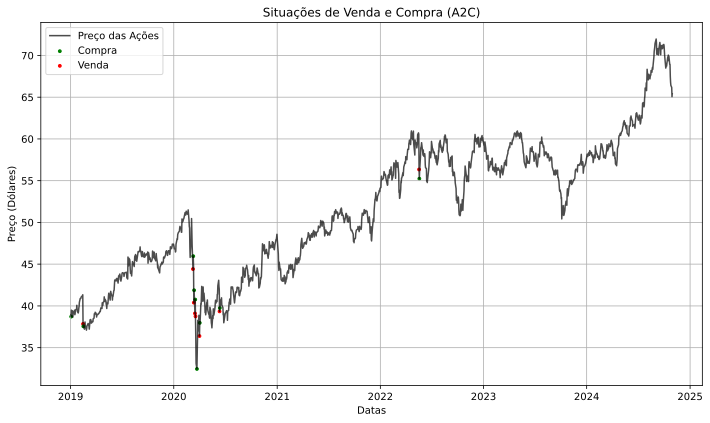

Sharpe Ratio: 0.635764156868842
CAGR: 11.353813315869798%
Cumulative Returns: 87.10082679748535%
Compound Cumulative Return: 87.10%
Variance: 0.01614645463266621%
CVaR: -3.042993356201585%


In [33]:
# Set random seeds
seed = 10000
random.seed(seed)
np.random.seed(seed)

# Fetch data
ko = yf.Ticker("KO")
data = ko.history(start="2019-01-01", end="2024-10-31")

# Define environment
window_size = 1
env = StocksEnv(
    df=data,
    window_size=window_size,
    frame_bound=(window_size, len(data))
)

# Train A2C model
env.reset(seed=seed)
model = A2C('MlpPolicy', 
            env,
            learning_rate=0.0005,
            gamma=0.99,
            n_steps=5,
            ent_coef=0.001,
            vf_coef=0.5,
            max_grad_norm=0.5,
            gae_lambda=0.95, 
            verbose=1)

model.set_random_seed(seed)
model.learn(total_timesteps=1000)

# #Define the entry and exit points
# entry_points = {
#     '2020-03-16': 'BUY',  # COVID WORLD PANDEMIC DECLARATION
#     '2022-09-01': 'BUY',  # MID-TERM ELECTIONS
#     '2023-08-01': 'BUY'   # FEDERAL RESERVE MONETARY POLICY UPDATE
# }

# exit_points = {
#     '2020-02-05': 'SELL', # PRE PANDEMIC WARNING
#     '2022-01-13': 'SELL', # RELEASE OF POSITIVE ECONOMICAL FORECAST
#     '2024-09-03': 'SELL'  # INTEREST RATE REDUCTION
# }

# Initialize variables for tracking performance
initial_balance = 10000  # Starting with an initial balance
balance = initial_balance
portfolio = {"cash": balance, "shares": 0}
price_history = []
portfolio_value_history = [initial_balance]
trades = []

# Map action indices to string actions
action_mapping = {0: "Buy", 1: "Sell"}

# Test the environment
observation, info = env.reset(seed=seed)
current_step = env.frame_bound[0]

while True:
   action, _states = model.predict(observation, deterministic=True)
    
    # Extract the scalar value from action (in case it is an ndarray)
   action = action.item() if isinstance(action, np.ndarray) else action

    # # Get the current date
    # current_date = data.index[current_step].strftime('%Y-%m-%d')

    # # Check for predefined entry or exit points
    # if current_date in entry_points and portfolio["cash"] > 0:
    #     action = 0  # Force a BUY action
    # elif current_date in exit_points and portfolio["shares"] > 0:
    #     action = 1  # Force a SELL action
    # else:
    #     # Use the model to predict the action
    #     action, _states = model.predict(observation, deterministic=True)
    #     action = action.item() if isinstance(action, np.ndarray) else action

   current_price = env.df.iloc[current_step]['Close']
   #print(f"Step: {current_step}, Action: {action_mapping[action]}, Price: {current_price}, Portfolio Value: {portfolio_value}, Cash: {portfolio['cash']}, Shares: {portfolio['shares']}")
            
    # Update portfolio based on action
   if action == 0 and portfolio["cash"] >= current_price:  # Buy
        portfolio["shares"] += math.floor(portfolio["cash"]/int(current_price))
        portfolio["cash"] = portfolio["cash"] - int(math.floor(portfolio["cash"]/int(current_price))*int(current_price))
        trades.append(('BUY', data.index[current_step], current_price, portfolio["shares"]))
   
   elif action == 1 and portfolio["shares"] > 0:  # Sell
        portfolio["cash"] += portfolio["shares"]*int(current_price)
        portfolio["shares"] = 0
        trades.append(('SELL', data.index[current_step], current_price, portfolio["shares"]))

    # Record portfolio value and price
   price_history.append(current_price)
   portfolio_value = portfolio["cash"] + portfolio["shares"] * current_price
   portfolio_value_history.append(portfolio_value)
    
    # Step to the next state
   observation, reward, terminated, truncated, info = env.step(action)
   current_step += 1
    
   if terminated or truncated:
        break
   

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label="Preço das Ações", color='black', alpha=0.7)

for trade in trades:
    action, date, price, shares = trade
    if action == 'BUY':
        plt.scatter(date, price, s=8, color='green', label="Compra" if 'Compra' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif action == 'SELL':
        plt.scatter(date, price, s=8, color='red', label="Venda" if 'Venda' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title('Situações de Venda e Compra (A2C)')
plt.xlabel('Datas')
plt.ylabel('Preço (Dólares)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


portfolio_value = np.array(portfolio_value_history)
returns = np.diff(portfolio_value_history) / portfolio_value_history[:-1]
sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)
cagr = (portfolio_value[-1] / portfolio_value[0]) ** (252 / len(data)) - 1
cumulative_returns = (portfolio_value[-1] - portfolio_value[0]) / portfolio_value[0]
variance = np.var(returns)
cvar = np.mean(returns[returns < np.percentile(returns, 5)])

daily_returns = np.diff(portfolio_value) / portfolio_value[:-1]
compound_cumulative_return = np.prod(1 + daily_returns) - 1

# Print metrics
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"CAGR: {cagr*100}%")
print(f"Cumulative Returns: {cumulative_returns*100}%")
print(f'Compound Cumulative Return: {compound_cumulative_return * 100:.2f}%')
print(f"Variance: {variance*100}%")
print(f"CVaR: {cvar*100}%")
